<a href="https://colab.research.google.com/github/quetion/time_series_11202/blob/main/TS_Ch4_%E9%A0%90%E6%B8%AC%E8%A1%A8%E7%8F%BE%E4%B9%8B%E8%A9%95%E4%BC%B0_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diebold-Mariano 檢定
- 以比特幣報酬為例
- 比較AR(1)與AR(2)的模型預測能力
- 利用Diebold-Mariano 檢定

In [1]:
# package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
#from statsmodels.regression.rolling import RollingOLS

In [22]:
data = yf.download('BTC-USD',start = '2020-01-01',end='2022-04-23')
data = data[['Adj Close']]
data.columns = ['price_btc']
data.index = pd.to_datetime(data.index)

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

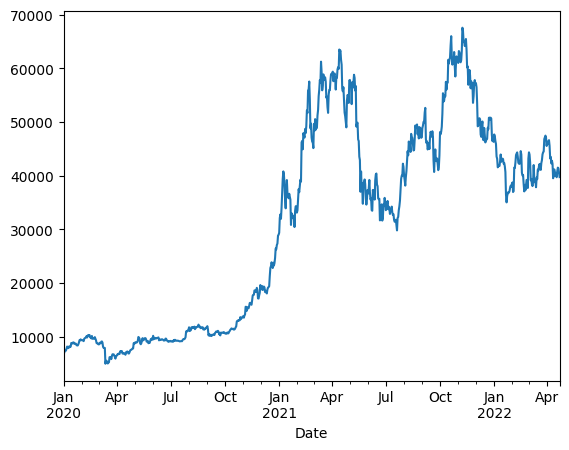

In [23]:
data.price_btc.plot()

## 設定自變數
- 報酬率
- 落後一期報酬率
- 落後二期報酬率

In [24]:
data['ret_btc'] = np.log(data.price_btc).diff()
data['ret_btc_1'] = data.ret_btc.shift(1)
data['ret_btc_2'] = data.ret_btc.shift(2)

<ipython-input-24-7414ec788121>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ret_btc'] = np.log(data.price_btc).diff()
<ipython-input-24-7414ec788121>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ret_btc_1'] = data.ret_btc.shift(1)
<ipython-input-24-7414ec788121>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [25]:
data.head()

,price_btc,ret_btc,ret_btc_1,ret_btc_2
Date,,,,
2020-01-01,7200.174316,NaN,NaN,NaN
2020-01-02,6985.470215,-0.030273,NaN,NaN
2020-01-03,7344.884277,0.050172,-0.030273,NaN
2020-01-04,7410.656738,0.008915,0.050172,-0.030273
2020-01-05,7411.317383,0.000089,0.008915,0.050172


## 設定樣本範圍
- 資料總數為`1190`
- 樣本內資料設定為`R=200`
- 樣本外資料設定為`P=990`


In [26]:
R = 200
P = len(data) - R
print(R,P)


200 643


In [27]:
y = data.ret_btc[0:200]
y

Date
2020-01-01         NaN
2020-01-02   -0.030273
2020-01-03    0.050172
2020-01-04    0.008915
2020-01-05    0.000089
                ...   
2020-07-14   -0.000043
2020-07-15   -0.005465
2020-07-16   -0.006615
2020-07-17    0.002096
2020-07-18    0.000835
Name: ret_btc, Length: 200, dtype: float64

In [28]:
# out-of-sample MSE
R = 200
P = len(data) - R
print(R,P)
#
e1 = np.zeros(P)
e2 = np.zeros(P)
for i in range(1,P-1):
    y = data.ret_btc[i:R+i]
    x = sm.add_constant(data.ret_btc_1[i:R+i])
    result_ar1 = sm.OLS(y,x,missing='drop').fit()
    x = sm.add_constant(data[['ret_btc_1','ret_btc_2']][i:R+i])
    result_ar2 = sm.OLS(y,x,missing='drop').fit()
    fitted_ar1 = result_ar1.params[0] + result_ar1.params[1]*data.ret_btc_1[R+i-1]
    fitted_ar2 = result_ar2.params[0] + result_ar2.params[1]*data.ret_btc_1[R+i-1] + result_ar2.params[2]*data.ret_btc_2[R+i-1]
    e1[i] = data.ret_btc[R+i] - fitted_ar1
    e2[i] = data.ret_btc[R+i] - fitted_ar2
mse_ar1_oos = np.mean(e1**2)
mse_ar2_oos = np.mean(e2**2)
print(mse_ar1_oos)
print(mse_ar2_oos)

200 643
0.0014372316328412978
0.0014614756236566557


In [29]:
print('AR(1) out-of-sample MSE = {:.4f}'.format(mse_ar1_oos))
print('AR(2) out-of-sample MSE = {:.4f}'.format(mse_ar2_oos))
y = e1**2 - e2**2
x = np.ones(len(y))
# 利用 Newey-West標準誤估計
rr = sm.OLS(y,x,missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':2})
print(rr.summary())

AR(1) out-of-sample MSE = 0.0014
AR(2) out-of-sample MSE = 0.0015
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 29 Apr 2024   Prob (F-statistic):                nan
Time:                        16:10:25   Log-Likelihood:                 4528.6
No. Observations:                 643   AIC:                            -9055.
Df Residuals:                     642   BIC:                            -9051.
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

## 判斷模型好壞
- MSE 直接比大小
- 檢定: pvalue

In [21]:
rr.pvalues

array([0.7224946])

## 範例練習
- 更換資料頻率成月頻率
- 更換標的資產: `S&P500指數`
- 如何匯出下載資料 `.to_csv()`


In [42]:
# 重新獲取資料
data = yf.download('BTC-USD',start = '2018-01-01',end='2022-04-23')
data = data[['Adj Close']]
data.columns = ['price_btc']
data.index = pd.to_datetime(data.index)


[*********************100%%**********************]  1 of 1 completed


In [44]:
# 變更成月頻率
data_m = data.resample('M').last().copy()

In [46]:
data_m.head()

,price_btc
Date,
2018-01-31,10221.099609
2018-02-28,10397.900391
2018-03-31,6973.529785
2018-04-30,9240.549805
2018-05-31,7494.169922


In [47]:
data_m['ret_btc'] = np.log(data_m.price_btc).diff()

In [48]:
# 變更成月頻率
data_m = data.resample('M').last().copy()
# 建立報酬率
data_m['ret_btc'] = np.log(data_m.price_btc).diff()
# 建立落後期
data_m['ret_btc_1'] = data_m.ret_btc.shift()
data_m['ret_btc_2'] = data_m.ret_btc.shift(2)

In [49]:
data_m.head()

,price_btc,ret_btc,ret_btc_1,ret_btc_2
Date,,,,
2018-01-31,10221.099609,NaN,NaN,NaN
2018-02-28,10397.900391,0.017150,NaN,NaN
2018-03-31,6973.529785,-0.399482,0.017150,NaN
2018-04-30,9240.549805,0.281480,-0.399482,0.017150
2018-05-31,7494.169922,-0.209476,0.281480,-0.399482
